# ACEA WATER ANALYTICS

How-to Multivariate Time series analysis.

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
!pip install odfpy 
from statsmodels.tsa.stattools import adfuller
import missingno as msno
import pickle 

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from keras import backend as K
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA

from statsmodels.tsa.vector_ar.var_model import VAR

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# RIVER

In [6]:
river = pd.read_csv('/kaggle/input/acea-water-prediction/River_Arno.csv') 
river.head()

,Date,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano
0,01/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.82
1,02/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.94
2,03/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.11
3,04/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.84
4,05/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.88


In [7]:
river.shape

(8217, 17)

## EDA

Checking amount of na values and removing them.

In [8]:
river.isnull().sum()

Date                            0
Rainfall_Le_Croci            2191
Rainfall_Cavallina           2191
Rainfall_S_Agata             2191
Rainfall_Mangona             2191
Rainfall_S_Piero             2191
Rainfall_Vernio              3934
Rainfall_Stia                6934
Rainfall_Consuma             6934
Rainfall_Incisa              3649
Rainfall_Montevarchi         6570
Rainfall_S_Savino            6934
Rainfall_Laterina            6934
Rainfall_Bibbiena            5839
Rainfall_Camaldoli           6934
Temperature_Firenze          2025
Hydrometry_Nave_di_Rosano      48
dtype: int64

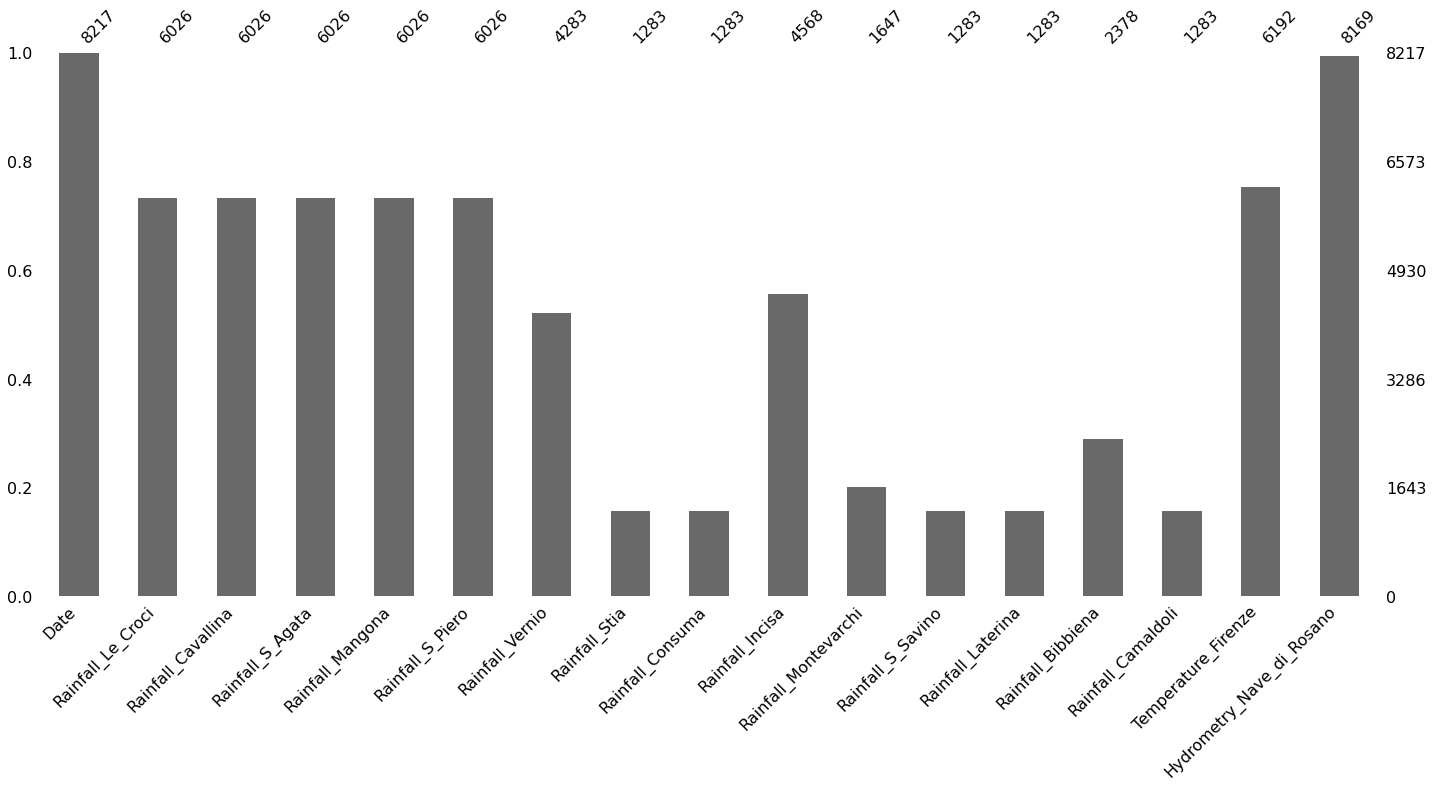

In [9]:
msno.bar(river)

In [10]:
river = river.dropna().reset_index()

In [11]:
river.shape

(1276, 18)

In [12]:
river['Date'] = pd.to_datetime(river['Date'], dayfirst=True)

Checking for non-stationarity in data and removing it.
Non stationary data create worse performing models in time series

In [13]:
for i in range(river.shape[1]):
    if i > 2:
        print(adfuller(river.iloc[:,i])[1])
        if adfuller(river.iloc[:,i])[1] > 0.05:
            print('{} has p value > 0.05'.format(river.columns.values[i]))
#column corrrosponding to temperature has non stationarity that needs to be removed

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.077474841483391e-24
0.1017418053350716
Temperature_Firenze has p value > 0.05
0.00211260775875418


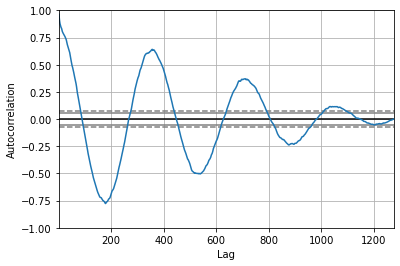

In [14]:
pd.plotting.autocorrelation_plot(river.iloc[:,-2])

In autocorrelation plot, it can be observed there is a cycly for roughly an year for temp.

In [15]:
river.iloc[:,-2] = river.iloc[:,-2].diff(1).fillna(river.iloc[:,-2].diff(1)[365])

In [16]:
for i in range(river.shape[1]):
    if i > 2:
        print(adfuller(river.iloc[:,i])[1])
        if adfuller(river.iloc[:,i])[1] > 0.05:
            print('{} has p value > 0.05'.format(river.columns.values[i]))
#column corrrosponding to temperature has non stationarity that needs to be removed

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.077474841483391e-24
1.1024559760018802e-24
0.00211260775875418


Text(0.5, 1.0, 'Correlation among the variables')

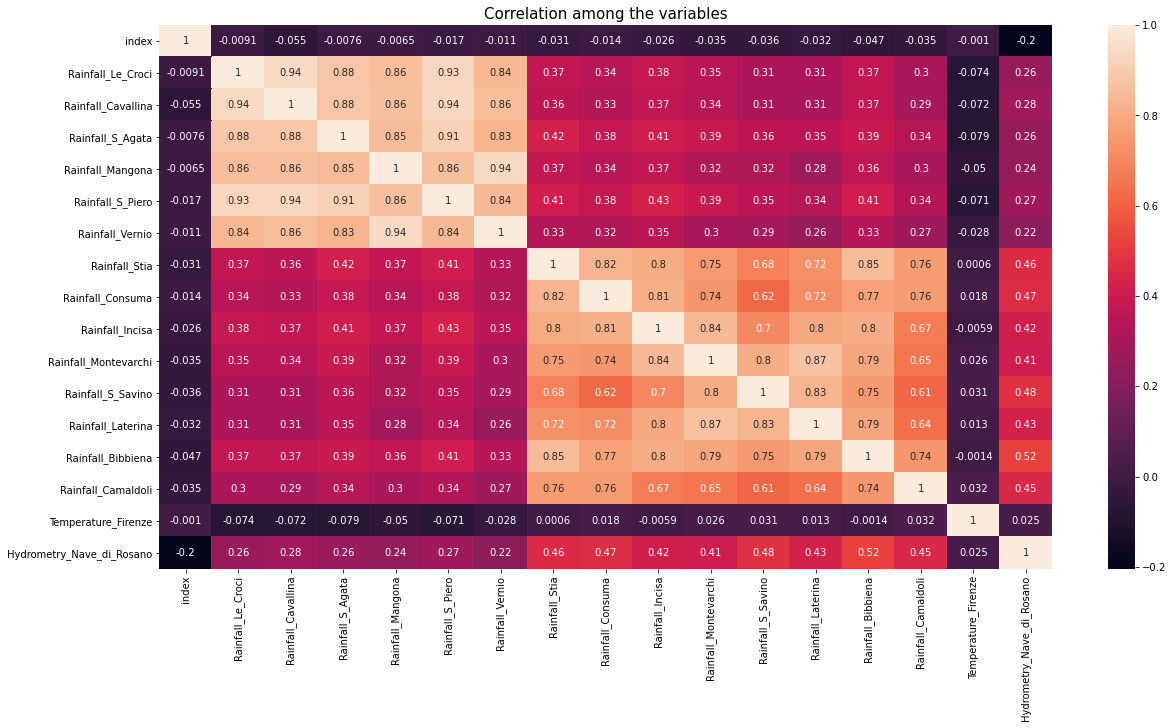

In [17]:
correlation = river.corr()
plt.figure(figsize=(20,10), facecolor='w')
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)
plt.title("Correlation among the variables", size=15)

## Features with > 0.4 corr

features with low correlation will not be used. As can be observed, certain Features have correlation below 0.4 and other have above 0.4. Only ones with 0.4 and above will be used

## Feature selection methods

following cell contains code for various feature selection methods

In [18]:
#PCA 
def pca(X,Y, col):
    scaler_rain = StandardScaler()
    scaled_feat = scaler_rain.fit_transform(X)
    pca = PCA(n_components=4)
    components = pca.fit_transform(scaled_feat)
    col_name = ['PCA1', 'PCA2', 'PCA3', 'PCA4']
    return [components, Y, col_name]

#TREE FEATURE IMPORTANCE
def tree_feat_imp(X,Y, col):
    estimator = RandomForestRegressor(n_estimators=500, random_state=1)
    estimator.fit(X, X[:,-1])
    id = list(estimator.feature_importances_.argsort()[-5:])
    features = X[:,id]
    names = river.iloc[:,2:].loc[:,list(col)].columns.values
    print('METHOD - random forest feature importance')
    print('important features : {}'.format(names[estimator.feature_importances_.argsort()[:-6:-1]]))
    col_name = names[estimator.feature_importances_.argsort()[:-6:-1]]
    return [features, Y, col_name]

#RFE
def rfe(X, Y, col):
    rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=5)
    fit = rfe.fit(X, Y)
    names = river.iloc[:,2:].loc[:,list(col)].columns.values
    print('METHOD - rfe')
    col_name = []
    for i in range(fit.support_.shape[0]):
        if fit.support_[i]:
            col_name.append(names[i])
    print(col_name)
    features = river.iloc[:,2:].loc[:,list(col)].loc[:,list(fit.support_)].copy().to_numpy()
    return [features, Y, col_name]

#F REGRESSION
def f_reg(X,Y, col):
    f_test,_ = f_regression(X,Y)
    id = list(abs(f_test).argsort()[:-6:-1])
    features = X[:,id]
    names = river.iloc[:,2:].loc[:,list(col)].columns.values
    print('METHOD - f regression')
    print('important features : {}'.format(names[abs(f_test).argsort()[:-6:-1]]))
    col_name = names[abs(f_test).argsort()[:-6:-1]]
    return [features, Y, col_name]

#MUTUAL INFO REGRESSION
def mutual_info(X,Y, col):
    mi = mutual_info_regression(X,Y)
    id = list(mi.argsort()[:-6:-1])
    features = X[:,id]
    names = river.iloc[:,2:].loc[:,list(col)].columns.values
    print('METHOD - mutual info regression')
    print('important features : {}'.format(names[mi.argsort()[:-6:-1]]))
    col_name = names[mi.argsort()[:-6:-1]]
    return [features, Y, col_name]

#PERMUTATION IMPORTANCE
def pi(X,Y, col):
    estimator = RandomForestRegressor().fit(X,Y)
    result = permutation_importance(estimator, X, Y, n_repeats=10)
    id = list(result.importances_mean.argsort()[:-6:-1])
    features = X[:,id]
    names = river.iloc[:,2:].loc[:,list(col)].columns.values
    print('METHOD - permutation importance')
    print('important features : {}'.format(names[result.importances_mean.argsort()[:-6:-1]]))
    col_name = names[result.importances_mean.argsort()[:-6:-1]]
    return [features, Y, col_name]

In [19]:
def select_features(method=dict()):
    col = (river.iloc[:,1:].corrwith(river['Hydrometry_Nave_di_Rosano'], axis=0) > 0.4)
    features = river.iloc[:,2:].loc[:,list(col)].copy().to_numpy()
    target = river['Hydrometry_Nave_di_Rosano'].copy().to_numpy()
    #following are various feature selection methods
    method['0.4_corr'] = [features,target, river.iloc[:,2:].loc[:,list(col)].columns.values]
    # '0.4_corr' contains features with more than 0.4 correlation with Hydrometry
    method['pca'] = pca(features, target, col)
    #'pca' contains features with 4 pca components, acounting for 90% variance
    method['tree'] = tree_feat_imp(features, target, col)
    #'tree' uses tree based models to select top 5 features
    method['rfe'] = rfe(features, target, col)
    #'rfe' uses recursive feature elimination to select top 5 features
    method['f_reg'] = f_reg(features,target, col)
    #selecting features using f regression
    method['mutual_info'] = mutual_info(features, target, col)
    #selecting features using mutual info
    method['perm_imp'] = pi(features, target, col)
    #selecting features using permutation importance
    return method

In [20]:
feat_sel_method = select_features()

METHOD - random forest feature importance
important features : ['Hydrometry_Nave_di_Rosano' 'Rainfall_Consuma' 'Rainfall_Stia'
 'Rainfall_Bibbiena' 'Rainfall_Laterina']
METHOD - rfe
['Rainfall_Stia', 'Rainfall_Consuma', 'Rainfall_Laterina', 'Rainfall_Bibbiena', 'Hydrometry_Nave_di_Rosano']
METHOD - f regression
important features : ['Hydrometry_Nave_di_Rosano' 'Rainfall_Bibbiena' 'Rainfall_S_Savino'
 'Rainfall_Consuma' 'Rainfall_Stia']
METHOD - mutual info regression
important features : ['Hydrometry_Nave_di_Rosano' 'Rainfall_Consuma' 'Rainfall_Laterina'
 'Rainfall_Incisa' 'Rainfall_Bibbiena']
METHOD - permutation importance
important features : ['Hydrometry_Nave_di_Rosano' 'Rainfall_Laterina' 'Rainfall_Bibbiena'
 'Rainfall_Consuma' 'Rainfall_Camaldoli']


## Models

### VAR

following loop contains training loop for VAR model

In [21]:
def VAR_training(feat_sel_dict):
    
    comparison={}
    for key in feat_sel_dict.keys():
        print('Method - {}'.format(key))
        x , xtest, y, ytest = train_test_split(feat_sel_dict[key][0],feat_sel_dict[key][1]
                                              , test_size=0.5, shuffle=False)

        scaler = StandardScaler()
        x = scaler.fit_transform(x)
        xtest = scaler.transform(xtest)

        xtrain = pd.DataFrame(data=x, columns = feat_sel_dict[key][2])

        model = VAR(xtrain)
        result = model.fit(maxlags=30, ic='aic')
        print('lag - {}'.format(result.k_ar))
        lag = result.k_ar

        model_lag = VAR(xtrain)
        result_lag = model_lag.fit(lag)
        result_lag.summary()

        xtest = pd.DataFrame(data=xtest, columns = feat_sel_dict[key][2])

        pred=[]
        for i in range(ytest.shape[0]-lag):
            val = result_lag.forecast(xtest.values[i:i+lag], steps=1)
            #print(val)
            pred.append(val)

        arr = np.array(pred)
        #arr shape : [no of samples ,1,no. of features]
        arr = np.squeeze(arr, axis=1)

        ypred = scaler.inverse_transform(arr)
        rounded = ypred[:,-1].round(2)

        rmse = tf.keras.metrics.RootMeanSquaredError()
        rmse.update_state(ytest[lag:], rounded)

        print('RMSE - {}'.format(rmse.result().numpy()))

        mae = tf.keras.losses.MeanAbsoluteError()
        mae = mae(ytest[lag:], rounded).numpy()

        print('MAE - {}'.format(mae))
        
        comparison[key] = {'RMSE':rmse.result().numpy(), 'lag':lag,
                          'forecast':pd.DataFrame({'pred': rounded,'test': ytest[lag:]})}
        
    return comparison

In [22]:
var = VAR_training(feat_sel_method)

Method - 0.4_corr
lag - 2
RMSE - 0.3077252209186554
MAE - 0.15536163747310638
Method - pca
lag - 1
RMSE - 1.6134860515594482
MAE - 1.4786027669906616
Method - tree
lag - 2
RMSE - 0.3002137541770935
MAE - 0.1508176028728485
Method - rfe
lag - 2
RMSE - 0.3002137541770935
MAE - 0.1508176028728485
Method - f_reg
lag - 1
RMSE - 1.968633770942688
MAE - 1.133908987045288
Method - mutual_info
lag - 2
RMSE - 3.0102672576904297
MAE - 1.3711320161819458
Method - perm_imp
lag - 2
RMSE - 4.772907257080078
MAE - 2.587327003479004


### LSTM

following cell contains trianing loop for lstm model.

In [23]:
''' model_type - 'feature_corr', 'pca_corr', 'tree_corr', 'rfe_corr', 'f_regression_corr', 
'mutual_info_corr', 'permutation_imp_corr'

This partitions features and targets in train/val/test set
 
'''
def training(X,Y,model_type, save=False):

    x, xtest, y, ytest = train_test_split(X, Y, test_size=0.5,
                                                shuffle=False)

    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    xtrain, xval, ytrain, yval = train_test_split(x, x[:,-1], test_size=0.1,
                                                shuffle=False)
    xtest = scaler.transform(xtest)

    models = {}
    models[model_type] = {}
    for lag in range(1, 8):
        train_generator = TimeseriesGenerator(xtrain, ytrain, length=lag, sampling_rate=1, batch_size=32)
        val_generator = TimeseriesGenerator(xval, yval, length=lag, sampling_rate=1, batch_size=32)
        test_generator = TimeseriesGenerator(xtest, ytest, length=lag, sampling_rate=1, batch_size=1)

        model = tf.keras.Sequential()
        model.add(tf.keras.layers.LSTM(64, activation='relu', input_shape=(lag, xtrain.shape[1]), return_sequences=False))
        model.add(tf.keras.layers.Dropout(0.3))
        model.add(tf.keras.layers.Dense(1))

        #model.summary()

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=2,
                                                        mode='min'
        )


        model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.keras.metrics.RootMeanSquaredError(),
                            tf.metrics.MeanAbsoluteError()]
        )


        history = model.fit(train_generator,
                          epochs=30,
                          validation_data=val_generator,
                          shuffle=False,
                          callbacks=[early_stopping],
                          verbose=0)
        print('------------- EVALUATION - {}-----------------'.format(lag))
        ypred = model.predict(test_generator)
        pred = np.repeat(ypred, xtrain.shape[1], axis=1)
        scaled = scaler.inverse_transform(pred)
        rounded = scaled[:,-1].round(2)

        test = ytest[-(ytest.shape[0]-lag):]

        rmse = tf.keras.metrics.RootMeanSquaredError()
        rmse.update_state(test, rounded)

        print('RMSE = {}'.format(rmse.result().numpy()))

        mae = tf.keras.losses.MeanAbsoluteError()
        mae = mae(test, rounded).numpy()

        print('MAE = {}'.format(mae))
        
        if save == True:

            models[model_type][lag] = {}
            models[model_type][lag]['prediction_metric'] = rmse.result().numpy()
            models[model_type][lag]['history'] = history.history
            models[model_type][lag]['forecast'] = pd.DataFrame({'pred': rounded, 
                                                                'test': test})
            return models

In [24]:
for key in feat_sel_method.keys():
    print('_____'+key+'_______')
    training(feat_sel_method[key][0], feat_sel_method[key][1], key)

_____0.4_corr_______
------------- EVALUATION - 1-----------------
RMSE = 0.5022661685943604
MAE = 0.35780221223831177
------------- EVALUATION - 2-----------------
RMSE = 0.34449875354766846
MAE = 0.1735377460718155
------------- EVALUATION - 3-----------------
RMSE = 0.34215667843818665
MAE = 0.1688189059495926
------------- EVALUATION - 4-----------------
RMSE = 0.331109881401062
MAE = 0.16652995347976685
------------- EVALUATION - 5-----------------
RMSE = 0.3466125726699829
MAE = 0.17706161737442017
------------- EVALUATION - 6-----------------
RMSE = 0.332913875579834
MAE = 0.16085442900657654
------------- EVALUATION - 7-----------------
RMSE = 0.34409162402153015
MAE = 0.16633914411067963
_____pca_______
------------- EVALUATION - 1-----------------
RMSE = 1.6018455028533936
MAE = 1.4789326190948486
------------- EVALUATION - 2-----------------
RMSE = 1.611744999885559
MAE = 1.483789324760437
------------- EVALUATION - 3-----------------
RMSE = 1.5958439111709595
MAE = 1.465102

In [25]:
lstm = training(feat_sel_method['rfe'][0], feat_sel_method['rfe'][1],
                'rfe', True)

------------- EVALUATION - 1-----------------
RMSE = 0.31306007504463196
MAE = 0.15792778134346008


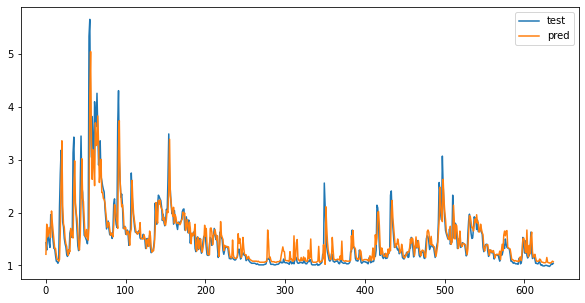

In [26]:
lstm['rfe'][1]['forecast'].plot(y=['test', 'pred'], figsize=(10,5))

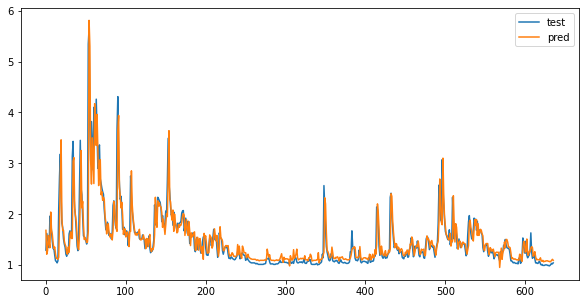

In [27]:
var['tree']['forecast'].plot(y=['test', 'pred'], figsize=(10,5))

Given the fact that Model - VAR has lower rmse. Additionally, in graphical representation it can be observed that var predicts peak values better than lstm, var model will be used for forecasting of final test set.

# Final TESTING

training a var model with combined data

In [28]:
def final_VAR_model(feat_sel_dict):
    
    for key in feat_sel_dict.keys():
        print('Method - {}'.format(key))
    
        scaler = StandardScaler()
        X = scaler.fit_transform(feat_sel_dict[key][0])

        xtrain = pd.DataFrame(data=X, columns = feat_sel_dict[key][2])

        model = VAR(xtrain)
        result = model.fit(maxlags=30, ic='aic')
        print('lag - {}'.format(result.k_ar))
        lag = result.k_ar

        model_lag = VAR(xtrain)
        result_lag = model_lag.fit(lag)
        result_lag.summary()
        
        if key == 'tree':
            result_lag.save('river_var_rmse_0.3_lag_3.pkl')
            pickle.dump(scaler, open('river_scaler_var_tree.pkl', 'wb'))#saving scaler to file 
            #scaler name contains details of relevant model and feature selection methods

In [29]:
final_VAR_model(feat_sel_method)

Method - 0.4_corr
lag - 3
Method - pca
lag - 3
Method - tree
lag - 3
Method - rfe
lag - 3
Method - f_reg
lag - 3
Method - mutual_info
lag - 3
Method - perm_imp
lag - 3


## Future Forecast

In [ ]:
#loading model and running it on test set
import statsmodels.api as sm
model = sm.load('var_rmse_0.3_lag_3.pickle') #model path
model.summary()#check if model loaded correctly

# 1. load test set of river dataframe in test
test 

# 2. run cell containing code of different feature selection methods
col = (test.iloc[:,1:].corrwith(test['Hydrometry_Nave_di_Rosano'], axis=0) > 0.4)
features = test.iloc[:,2:].loc[:,list(col)].copy().to_numpy()#selects all columns except index and datatime
target = test['Hydrometry_Nave_di_Rosano'].copy().to_numpy()
X,Y, col_name = tree_feat_imp(features,target)

# 3. scale data using same scaler
scaler = load(open('scaler.pkl', 'rb'))
X = scaler.transform(X)

# 4. preparing input for VAR model
xtest = pd.DataFrame(data=X, columns = col_name)

lag = 3 # lag of saved model

In [ ]:
#define how far in future do you want the forcasts for
# EX : for a week in future, steps = 7
steps = 
forecast = model.forecast(xtest.values[i:i+lag], steps=)

ypred = scaler.inverse_transform(forecast)

In [ ]:
'''
in case you want to predict data for next day
given the data of selected features for past number of days

lag = number for days

'''
pred=[]
for i in range(ytest.shape[0]-lag):
    val = model.forecast(xtest.values[i:i+lag], steps=1)
    pred.append(val)

arr = np.array(pred)
#arr shape : [no of samples ,1,no. of features]
arr = np.squeeze(arr, axis=1)

ypred = scaler.inverse_transform(arr)

In [ ]:
rounded = ypred[:,-1].round(2)

rmse = tf.keras.metrics.RootMeanSquaredError()

rmse.update_state(target[lag:], rounded)

print('RMSE - {}'.format(rmse.result().numpy()))

mae = tf.keras.losses.MeanAbsoluteError()
mae = mae(target[lag:], rounded).numpy()

print('MAE - {}'.format(mae))

# LAKE

In [30]:
lake = pd.read_csv('/kaggle/input/acea-water-prediction/Lake_Bilancino.csv') 
lake.head()

,Date,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
0,03/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
1,04/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2,05/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
3,06/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
4,07/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.44,0.31


In [31]:
lake.shape

(6603, 9)

## EDA

In [32]:
lake.isnull().sum()

Date                      0
Rainfall_S_Piero        577
Rainfall_Mangona        577
Rainfall_S_Agata        577
Rainfall_Cavallina      577
Rainfall_Le_Croci       577
Temperature_Le_Croci    578
Lake_Level                0
Flow_Rate                21
dtype: int64

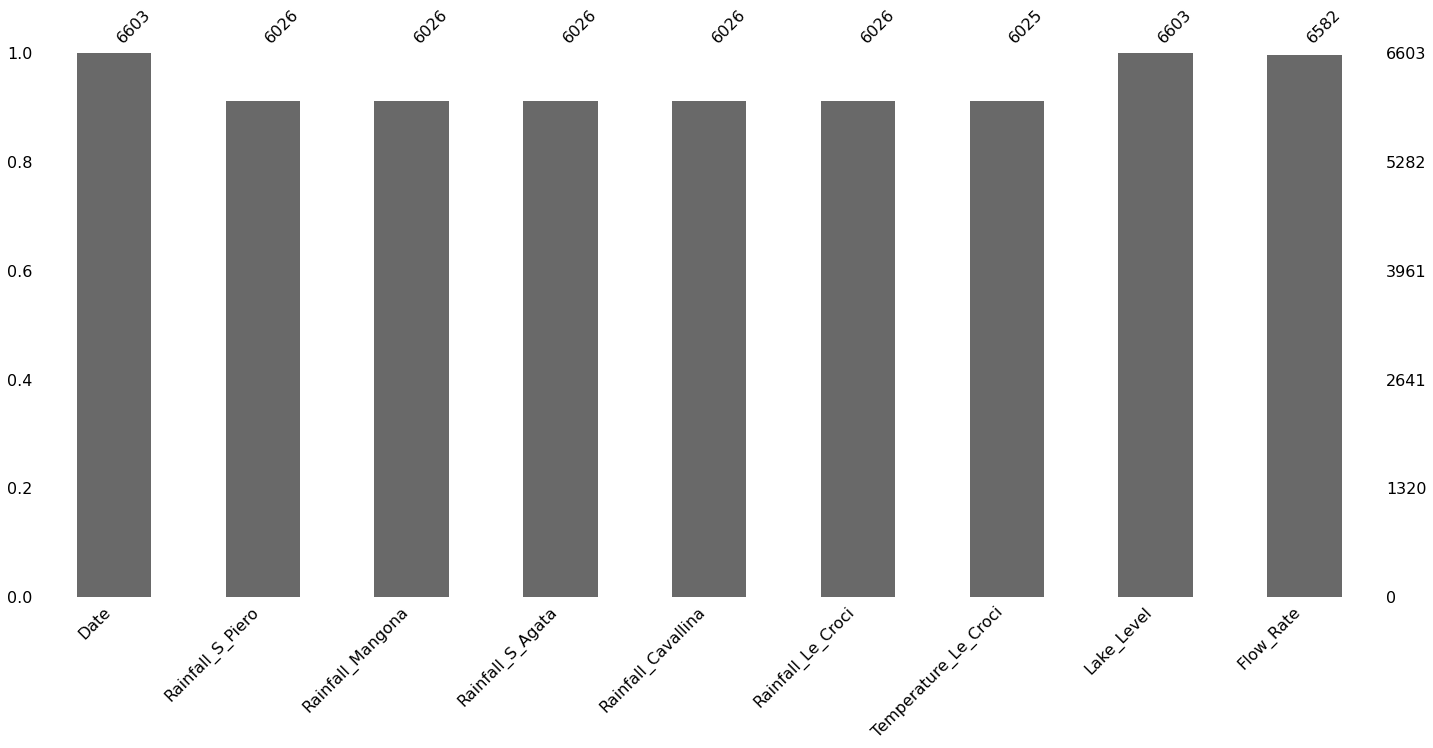

In [33]:
msno.bar(lake)

In [34]:
lake = lake.dropna().reset_index()

In [35]:
lake.shape

(6025, 10)

In [46]:
lake.head()

,index,Date,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
0,578,2004-01-02,0.0,0.0,0.0,0.0,0.0,6.50,251.21,0.5
1,579,2004-01-03,0.0,0.0,0.0,0.0,0.0,4.45,251.28,0.5
2,580,2004-01-04,0.0,0.0,0.0,0.0,0.0,2.00,251.35,0.5
3,581,2004-01-05,0.2,0.0,0.0,0.0,0.0,0.90,251.37,0.5
4,582,2004-01-06,0.0,0.0,0.0,0.0,0.0,2.25,251.42,0.5


In [36]:
lake['Date'] = pd.to_datetime(lake['Date'], dayfirst=True)

In [37]:
for i in range(lake.shape[1]):
    if i > 2:
        print(adfuller(lake.iloc[:,i])[1])
        if adfuller(lake.iloc[:,i])[1] > 0.05:
            print('-'*20)
            print('{} has p value > 0.05'.format(lake.columns.values[i]))
            print('-'*20)

8.044665857893697e-29
0.0
0.0
0.0
0.00012529899651088277
7.726366762781976e-07
1.1321317252147584e-17


Text(0.5, 1.0, 'Correlation among the variables')

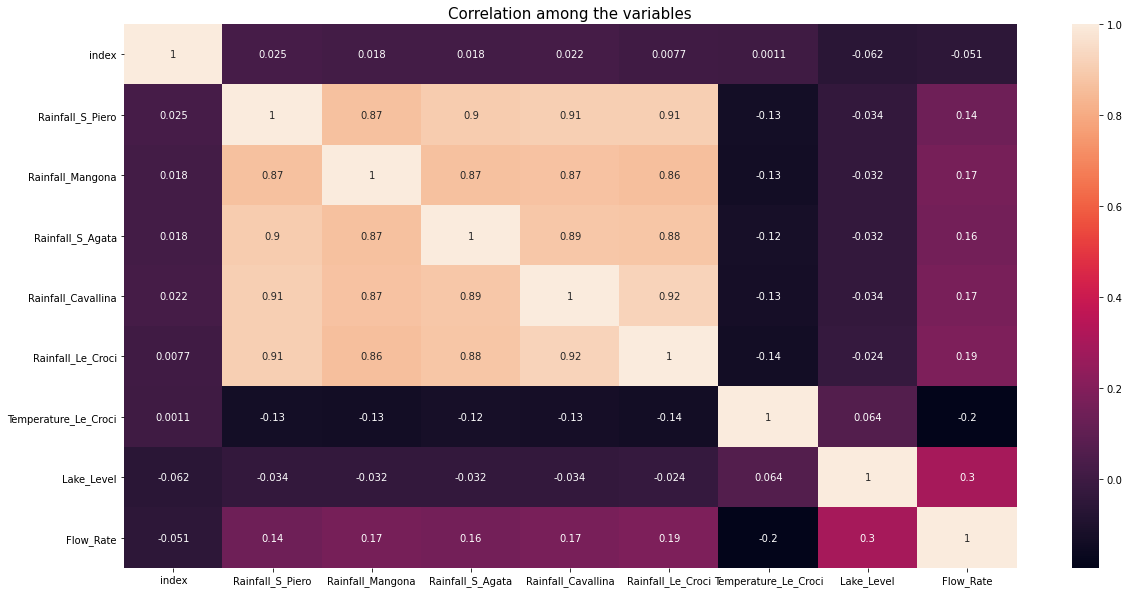

In [38]:
correlation = lake.corr()
plt.figure(figsize=(20,10), facecolor='w')
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)
plt.title("Correlation among the variables", size=15)

In [93]:
#PCA 
def pca(X,Y):
    scaler_rain = StandardScaler()
    scaled_feat = scaler_rain.fit_transform(X)
    pca_var = PCA(n_components=3)
    var = pca_var.fit(scaled_feat)
    pca = PCA(n_components=3)
    components = pca.fit_transform(scaled_feat)
    col_name = ['PCA1', 'PCA2', 'PCA3']
    print('METHOD - PCA')
    print('feature variance = {}'.format(sum(var.explained_variance_ratio_.round(2))))
    return [components, Y, col_name]

#TREE FEATURE IMPORTANCE
def tree_feat_imp(X,Y):
    estimator = RandomForestRegressor(n_estimators=500, random_state=1)
    estimator.fit(X, X[:,-1])
    id = list(estimator.feature_importances_.argsort()[:-4:-1])
    features = X[:,id]
    names = lake.iloc[:,2:].columns.values
    print('METHOD - random forest feature importance')
    print('important features : {}'.format(names[estimator.feature_importances_.argsort()[:-4:-1]]))
    col_name = names[estimator.feature_importances_.argsort()[:-4:-1]]
    return [features, Y, col_name]

#RFE
def rfe(X, Y):
    rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=3)
    fit = rfe.fit(X, Y)
    names = lake.iloc[:,2:].columns.values
    print('METHOD - rfe')
    col_name = []
    for i in range(fit.support_.shape[0]):
        if fit.support_[i]:
            col_name.append(names[i])
    print(col_name)
    features = lake.iloc[:,2:].loc[:,list(fit.support_)].copy().to_numpy()
    return [features, Y, col_name]

#F REGRESSION
def f_reg(X,Y):
    f_test,_ = f_regression(X,Y)
    id = list(abs(f_test).argsort()[:-4:-1])
    features = X[:,id]
    names = lake.iloc[:,2:].columns.values
    print('METHOD - f regression')
    print('important features : {}'.format(names[abs(f_test).argsort()[:-4:-1]]))
    col_name = names[abs(f_test).argsort()[:-4:-1]]
    return [features, Y, col_name]

#MUTUAL INFO REGRESSION
def mutual_info(X,Y):
    mi = mutual_info_regression(X,Y)
    id = list(mi.argsort()[:-4:-1])
    features = X[:,id]
    names = lake.iloc[:,2:].columns.values
    print('METHOD - mutual info regression')
    print('important features : {}'.format(names[mi.argsort()[:-4:-1]]))
    col_name = names[mi.argsort()[:-4:-1]]
    return [features, Y, col_name]

#PERMUTATION IMPORTANCE
def pi(X,Y):
    estimator = RandomForestRegressor().fit(X,Y)
    result = permutation_importance(estimator, X, Y, n_repeats=10)
    id = list(result.importances_mean.argsort()[:-4:-1])
    features = X[:,id]
    names = lake.iloc[:,2:].columns.values
    print('METHOD - permutation importance')
    print('important features : {}'.format(names[result.importances_mean.argsort()[:-4:-1]]))
    col_name = names[result.importances_mean.argsort()[:-4:-1]]
    return [features, Y, col_name]

In [40]:
lake.columns.values

array(['index', 'Date', 'Rainfall_S_Piero', 'Rainfall_Mangona',
       'Rainfall_S_Agata', 'Rainfall_Cavallina', 'Rainfall_Le_Croci',
       'Temperature_Le_Croci', 'Lake_Level', 'Flow_Rate'], dtype=object)

In [94]:
def select_features(y):
    
    method = {}
    
    features = lake.iloc[:,2:].copy().to_numpy()
    target = lake[y].copy().to_numpy()
    #following are various feature selection methods
    method['all'] = [features,target, lake.iloc[:,2:].columns.values]
    # '0.4_corr' contains features with more than 0.4 correlation with Hydrometry
    #method['pca'] = pca(features, target)
    #'pca' contains features with 4 pca components, acounting for 90% variance
    method['tree'] = tree_feat_imp(features, target)
    #'tree' uses tree based models to select top 5 features
    method['rfe'] = rfe(features, target)
    #'rfe' uses recursive feature elimination to select top 5 features
    method['f_reg'] = f_reg(features,target)
    #selecting features using f regression
    method['mutual_info'] = mutual_info(features, target)
    #selecting features using mutual info
    method['perm_imp'] = pi(features, target)
    #selecting features using permutation importance
    return method

In [98]:
flow = select_features('Flow_Rate')

METHOD - random forest feature importance
important features : ['Flow_Rate' 'Lake_Level' 'Rainfall_S_Agata']
METHOD - rfe
['Rainfall_S_Agata', 'Lake_Level', 'Flow_Rate']
METHOD - f regression
important features : ['Flow_Rate' 'Lake_Level' 'Temperature_Le_Croci']
METHOD - mutual info regression
important features : ['Flow_Rate' 'Lake_Level' 'Temperature_Le_Croci']
METHOD - permutation importance
important features : ['Flow_Rate' 'Rainfall_S_Agata' 'Lake_Level']


In [95]:
level = select_features('Lake_Level')

METHOD - random forest feature importance
important features : ['Flow_Rate' 'Lake_Level' 'Rainfall_S_Agata']
METHOD - rfe
['Temperature_Le_Croci', 'Lake_Level', 'Flow_Rate']
METHOD - f regression
important features : ['Lake_Level' 'Flow_Rate' 'Temperature_Le_Croci']
METHOD - mutual info regression
important features : ['Lake_Level' 'Flow_Rate' 'Temperature_Le_Croci']
METHOD - permutation importance
important features : ['Lake_Level' 'Flow_Rate' 'Temperature_Le_Croci']


In [81]:
def VAR_training(feat_sel_dict, ycol):
    
    comparison={}

    for key in feat_sel_dict.keys():
        print('Method - {}'.format(key))
        x , xtest, y, ytest = train_test_split(feat_sel_dict[key][0],feat_sel_dict[key][1]
                                              , test_size=0.5, shuffle=False)

        scaler = StandardScaler()
        x = scaler.fit_transform(x)
        xtest = scaler.transform(xtest)

        xtrain = pd.DataFrame(data=x, columns = feat_sel_dict[key][2])

        model = VAR(xtrain)
        result = model.fit(maxlags=30, ic='aic')
        print('lag - {}'.format(result.k_ar))
        lag = result.k_ar

        model_lag = VAR(xtrain)
        result_lag = model_lag.fit(lag)
        result_lag.summary()

        xtest = pd.DataFrame(data=xtest, columns = feat_sel_dict[key][2])
        if ycol == 'Flow_Rate':
            idx = xtest.columns.get_loc('Flow_Rate')
        else:
            idx = xtest.columns.get_loc('Lake_Level')
        
        pred=[]
        for i in range(ytest.shape[0]-lag):
            val = result_lag.forecast(xtest.values[i:i+lag], steps=1)
            #print(val)
            pred.append(val)

        arr = np.array(pred)
        #arr shape : [no of samples ,1,no. of features]
        arr = np.squeeze(arr, axis=1)

        ypred = scaler.inverse_transform(arr)
        rounded = ypred[:,idx].round(2)

        rmse = tf.keras.metrics.RootMeanSquaredError()
        rmse.update_state(ytest[lag:], rounded)

        print('RMSE - {}'.format(rmse.result().numpy()))

        mae = tf.keras.losses.MeanAbsoluteError()
        mae = mae(ytest[lag:], rounded).numpy()

        print('MAE - {}'.format(mae))

In [82]:
var_flow = VAR_training(flow, 'Flow_Rate')

Method - all
lag - 4
RMSE - 2.336334466934204
MAE - 0.765839159488678
Method - tree
lag - 21
RMSE - 4.295191287994385
MAE - 2.3853509426116943
Method - rfe
lag - 21
RMSE - 2.3910715579986572
MAE - 0.7932453155517578
Method - f_reg
lag - 21
RMSE - 2.4063901901245117
MAE - 0.7262666821479797
Method - mutual_info
lag - 21
RMSE - 2.4063901901245117
MAE - 0.7262666821479797
Method - perm_imp
lag - 21
RMSE - 2.3910715579986572
MAE - 0.7932453155517578


In [83]:
var_level = VAR_training(level, 'Lake_Level')

Method - all
lag - 4
RMSE - 0.08896305412054062
MAE - 0.03820538520812988
Method - tree
lag - 21
RMSE - 0.08866740763187408
MAE - 0.03665441274642944
Method - rfe
lag - 21
RMSE - 0.09654504060745239
MAE - 0.03804812952876091
Method - f_reg
lag - 21
RMSE - 0.09654504060745239
MAE - 0.03804812952876091
Method - mutual_info
lag - 21
RMSE - 0.09654504060745239
MAE - 0.03804812952876091
Method - perm_imp
lag - 21
RMSE - 0.09654504060745239
MAE - 0.03804812952876091


In [105]:
''' model_type - 'feature_corr', 'pca_corr', 'tree_corr', 'rfe_corr', 'f_regression_corr', 
'mutual_info_corr', 'permutation_imp_corr'

This partitions features and targets in train/val/test set
 
'''
def training(X,Y,model_type,ycol,save=False):

    x, xtest, y, ytest = train_test_split(X, Y, test_size=0.5,
                                                shuffle=False)

    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    xtrain, xval, ytrain, yval = train_test_split(x, y, test_size=0.1,
                                                shuffle=False)
    xtest = scaler.transform(xtest)
    
    if ycol == 'Flow_Rate':
        if model_type in ['all','rfe']:
            idx = -1
        else:    
            idx = 1 
    else:
        idx = -2
    
    
    models = {}
    models[model_type] = {}
    for lag in range(1, 30):
        train_generator = TimeseriesGenerator(xtrain, ytrain, length=lag, sampling_rate=1, batch_size=32)
        val_generator = TimeseriesGenerator(xval, yval, length=lag, sampling_rate=1, batch_size=32)
        test_generator = TimeseriesGenerator(xtest, ytest, length=lag, sampling_rate=1, batch_size=1)

        model = tf.keras.Sequential()
        model.add(tf.keras.layers.LSTM(64, activation='relu', input_shape=(lag, xtrain.shape[1]), return_sequences=False))
        model.add(tf.keras.layers.Dropout(0.3))
        model.add(tf.keras.layers.Dense(1))

        #model.summary()

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=2,
                                                        mode='min'
        )


        model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.keras.metrics.RootMeanSquaredError(),
                            tf.metrics.MeanAbsoluteError()]
        )


        history = model.fit(train_generator,
                          epochs=30,
                          validation_data=val_generator,
                          shuffle=False,
                          callbacks=[early_stopping],
                          verbose=0)
        
        
        print('------------- EVALUATION - {}-----------------'.format(lag))
        ypred = model.predict(test_generator)
        pred = np.repeat(ypred, xtrain.shape[1], axis=1)
        scaled = scaler.inverse_transform(pred)    
        rounded = scaled[:,idx].round(2)

        test = ytest[-(ytest.shape[0]-lag):]

        rmse = tf.keras.metrics.RootMeanSquaredError()
        rmse.update_state(test, rounded)

        print('RMSE = {}'.format(rmse.result().numpy()))

        mae = tf.keras.losses.MeanAbsoluteError()
        mae = mae(test, rounded).numpy()

        print('MAE = {}'.format(mae))
        
        if save == True:

            models[model_type][lag] = {}
            models[model_type][lag]['prediction_metric'] = rmse.result().numpy()
            models[model_type][lag]['history'] = history.history
            models[model_type][lag]['forecast'] = pd.DataFrame({'pred': rounded, 
                                                                'test': test})
            return models

In [108]:
for i in flow.keys():
    print(i)
    print(flow[i][0][:5], flow[i][1][:3], flow[i][2])

all
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.5000e+00
  2.5121e+02 5.0000e-01]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 4.4500e+00
  2.5128e+02 5.0000e-01]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.0000e+00
  2.5135e+02 5.0000e-01]
 [2.0000e-01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 9.0000e-01
  2.5137e+02 5.0000e-01]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.2500e+00
  2.5142e+02 5.0000e-01]] ['Rainfall_S_Piero' 'Rainfall_Mangona' 'Rainfall_S_Agata'
 'Rainfall_Cavallina' 'Rainfall_Le_Croci' 'Temperature_Le_Croci'
 'Lake_Level' 'Flow_Rate']
tree
[[  0.5  251.21   0.  ]
 [  0.5  251.28   0.  ]
 [  0.5  251.35   0.  ]
 [  0.5  251.37   0.  ]
 [  0.5  251.42   0.  ]] ['Flow_Rate' 'Lake_Level' 'Rainfall_S_Agata']
rfe
[[  0.   251.21   0.5 ]
 [  0.   251.28   0.5 ]
 [  0.   251.35   0.5 ]
 [  0.   251.37   0.5 ]
 [  0.   251.42   0.5 ]] ['Rainfall_S_Agata', 'Lake_Level', 'Flow_Rate']
f_reg
[[  0.5  251.21   6.5 ]
 [  0

In [106]:
for key in ['all', 'tree', 'rfe']:
    print('_____'+key+'_______')
    training(flow[key][0], flow[key][1], key, 'Flow_Rate')

_____all_______
------------- EVALUATION - 1-----------------
RMSE = 13.868792533874512
MAE = 9.68921184539795
------------- EVALUATION - 2-----------------
RMSE = 13.062928199768066
MAE = 9.924247741699219
------------- EVALUATION - 3-----------------
RMSE = 13.809253692626953
MAE = 10.108126640319824
------------- EVALUATION - 4-----------------
RMSE = 13.15536117553711
MAE = 10.065122604370117
------------- EVALUATION - 5-----------------
RMSE = 15.026917457580566
MAE = 11.350417137145996
------------- EVALUATION - 6-----------------
RMSE = 13.268693923950195
MAE = 9.915265083312988
------------- EVALUATION - 7-----------------
RMSE = 12.850865364074707
MAE = 9.982671737670898
------------- EVALUATION - 8-----------------
RMSE = 12.563766479492188
MAE = 10.174535751342773
------------- EVALUATION - 9-----------------
RMSE = 13.854408264160156
MAE = 10.404267311096191
------------- EVALUATION - 10-----------------
RMSE = 11.985063552856445
MAE = 9.67946720123291
------------- EVALUAT

KeyboardInterrupt: 

In [89]:
for key in ['all', 'tree', 'rfe']:
    print('_____'+key+'_______')
    training(level[key][0], level[key][1], key, 'Lake_Level')

_____all_______
------------- EVALUATION - 1-----------------
RMSE = 673.2967529296875
MAE = 626.8993530273438
------------- EVALUATION - 2-----------------
RMSE = 715.3978881835938
MAE = 714.7836303710938
------------- EVALUATION - 3-----------------
RMSE = 717.041259765625
MAE = 716.025146484375
------------- EVALUATION - 4-----------------
RMSE = 719.2166748046875
MAE = 717.3535766601562
------------- EVALUATION - 5-----------------
RMSE = 715.7201538085938
MAE = 713.9821166992188
------------- EVALUATION - 6-----------------
RMSE = 738.0587158203125
MAE = 734.4739990234375
------------- EVALUATION - 7-----------------
RMSE = 768.7958374023438
MAE = 760.8078002929688
------------- EVALUATION - 8-----------------
RMSE = 728.9979248046875
MAE = 727.2550659179688


KeyboardInterrupt: 